# Optical character recognition
This project demonstrates how to predict character from a 5x5 matrix, represented as as vector of n=25 using an only mathematical approach. Only the charracters J, D and N will be used for recognition. Inner products, correlation matrices and dot products are at the center of this project.
By Jaden van Rijswijk.

In [212]:
import numpy as np
import random
import math
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [264]:
def visualise_character(character) -> None:
    for i in range(5):
        for j in range(5):
            if character[i*5 + j] > 0.5:
                print("█", end="")
            else:
                print(" ", end="")
        print()
        
def visualise_probability_matrix(character) -> None:
    for i in range(5):
        for j in range(5):
            print(f"{character[i*5 + j]:.2f} ", end="")
        print()
        
def make_blurred(character, blur_level=0.2, min_value=0) -> list[int]:
    blurred_character = []
    for value in character:
        if value > 0.5:
            blurred_character.append(random.uniform(max(min_value, value - blur_level), 1))
        else:
            blurred_character.append(value)
            
    assert len(blurred_character) == 25
    return blurred_character

def make_noisy(character, noise_level=0.2, max_value=1) -> list[int]:
    noisy_character = []
    for value in character:
        if value < 0.5:
            noisy_character.append(random.uniform(0, min(value + noise_level, max_value)))
        else:
            noisy_character.append(value)
            
    assert len(noisy_character) == 25
    return noisy_character

def make_dropout(vector, drop_prob=0.1):
    return [v if random.random() > drop_prob else 0 for v in vector]

In [265]:
noise_level = 0.4
blur_level = 0.4 
drop_prob = 0.2
chars = ['j', 'd', 'n']

j_perfect = [1,1,1,1,1,-0.1,-0.1,-0.1,-0.1,1,-0.1,-0.1,-0.1,-0.1,1,1,-0.1,-0.1,-0.1,1,-0.1,1,1,1,1]
d_perfect = [1,1,1,1,-0.1,1,-0.1,-0.1,-0.1,1,1,-0.1,-0.1,-0.1,1,1,-0.1,-0.1,-0.1,1,1,1,1,1,-0.1]
n_perfect = [1,-0.1,-0.1,-0.1,1,1,1,-0.1,-0.1,1,1,-0.1,1,-0.1,1,1,-0.1,-0.1,1,1,1,-0.1,-0.1,-0.1,1]

assert len(j_perfect) == 25
assert len(d_perfect) == 25
assert len(n_perfect) == 25

char_vectors = pd.DataFrame(columns=['character', 'type', 'vector'])

for c in chars:
    char_vectors.loc[len(char_vectors)] = [c, f'{c}perfect', eval(f"{c}_perfect")]
    blurred = make_blurred(eval(f"{c}_perfect"), blur_level=blur_level, min_value=-0.1)
    char_vectors.loc[len(char_vectors)] = [c, f'{c}blurred', blurred]
    char_vectors.loc[len(char_vectors)] = [c, f'{c}noisy', make_noisy(eval(f"{c}_perfect"), noise_level=noise_level)]
    char_vectors.loc[len(char_vectors)] = [c, f'{c}dropout', make_dropout(eval(f"{c}_perfect"), drop_prob=drop_prob)]
    
visualise_character(j_perfect)
visualise_character(d_perfect)
visualise_character(n_perfect)

█████
    █
    █
█   █
 ████
████ 
█   █
█   █
█   █
████ 
█   █
██  █
█ █ █
█  ██
█   █


/var/folders/1h/x09k_pgn39d4j1gx2br0k3hm0000gn/T/ipykernel_59742/2171192677.py:22: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  correlations = correlations.groupby(lambda x: x[0]).mean().groupby(lambda x: x[0], axis=1).mean()


<Axes: xlabel='type', ylabel='type'>

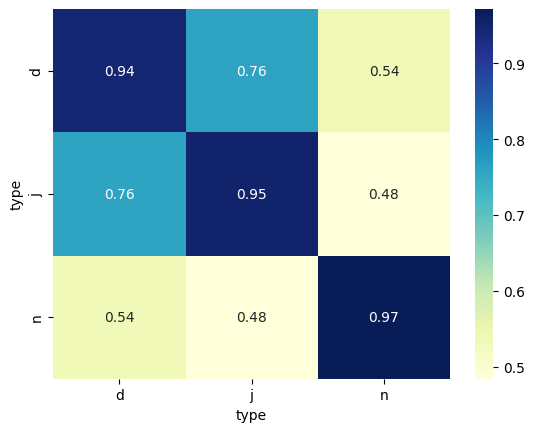

In [266]:
def magnitude(c):
    sum_squares = sum([x**2 for x in c])
    return math.sqrt(sum_squares)

def inner_product(x, y):
    return sum([x_i* y_i for x_i, y_i in zip(x, y)])

def cosine_similarity(x, y):
    return inner_product(x, y) / (magnitude(x) * magnitude(y))

def eucladian_distance(x, y):
    return math.sqrt(sum([(x_i - y_i)**2 for x_i, y_i in zip(x, y)]))

def make_correlation_matrix(avg_per_char=False):
    correlations = pd.DataFrame(index=char_vectors['type'], columns=char_vectors['type'])
    
    for i, row_i in char_vectors.iterrows():
        for j, row_j in char_vectors.iterrows():
            correlations.at[f"{row_i['type']}", f"{row_j['type']}"] = cosine_similarity(row_i['vector'], row_j['vector'])
                
    if avg_per_char:
        correlations = correlations.groupby(lambda x: x[0]).mean().groupby(lambda x: x[0], axis=1).mean()
        
    return correlations

correlation_matrix = make_correlation_matrix(avg_per_char=True)
sns.heatmap(correlation_matrix.astype(float), annot=True, cmap="YlGnBu")


From the heatmap can be seen the characters D and J are most similar, so thereby highest possibility to be confused

<Axes: xlabel='type', ylabel='type'>

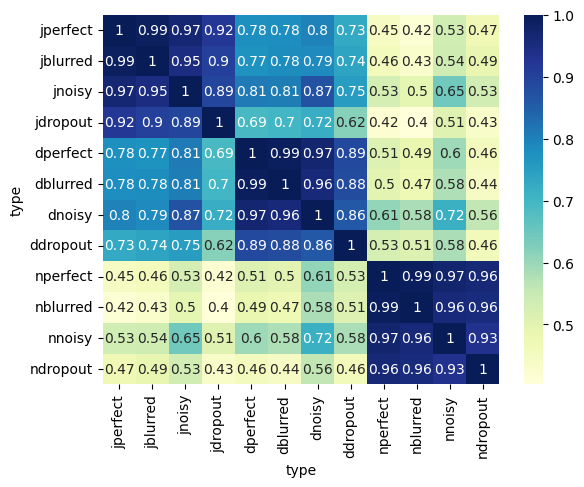

In [267]:
correlation_matrix = make_correlation_matrix()
sns.heatmap(correlation_matrix.astype(float), annot=True, cmap="YlGnBu")

In the complete correlation matrix above can be seen that the correlation between d and j is very high (around 0.8) for perfect, noisy, blurred and both. Whereby the noisy of j and d is the highest combination of 0.88 cosine similarity. This will complicate the detection.

In [268]:
grouped_chars = char_vectors.groupby('character')['vector']
NN1 = np.array([])

for char in chars:
    stck = np.stack(grouped_chars.get_group(char).to_numpy()).mean(axis=0)
    NN1 = np.append(NN1, stck)
    
NN1.resize((3, 25))

## Evaluation & Insights

[10.29467165  9.0441746   6.26284268]
The input vector is most likely a 'j' with a confidence of 40.21%


/var/folders/1h/x09k_pgn39d4j1gx2br0k3hm0000gn/T/ipykernel_59742/4006862505.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=chars, y=result, palette="husl")


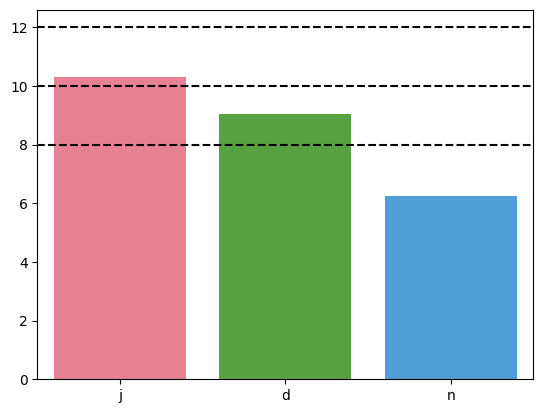

In [269]:
# Multiply NN1 with the input vector 
input_vector = make_noisy(make_blurred(j_perfect, blur_level=0.2), noise_level=0.34)
result = NN1 @ input_vector
print(result)
print(f"The input vector is most likely a '{chars[np.argmax(result)]}' with a confidence of {max(result)/sum(result)*100:.2f}%")

ax = sns.barplot(x=chars, y=result, palette="husl")
ax.axhline(y=8, color="black", linestyle="--")
ax.axhline(y=10, color="black", linestyle="--")
ax.axhline(y=12, color="black", linestyle="--")

## Test confidence with increasing distortion

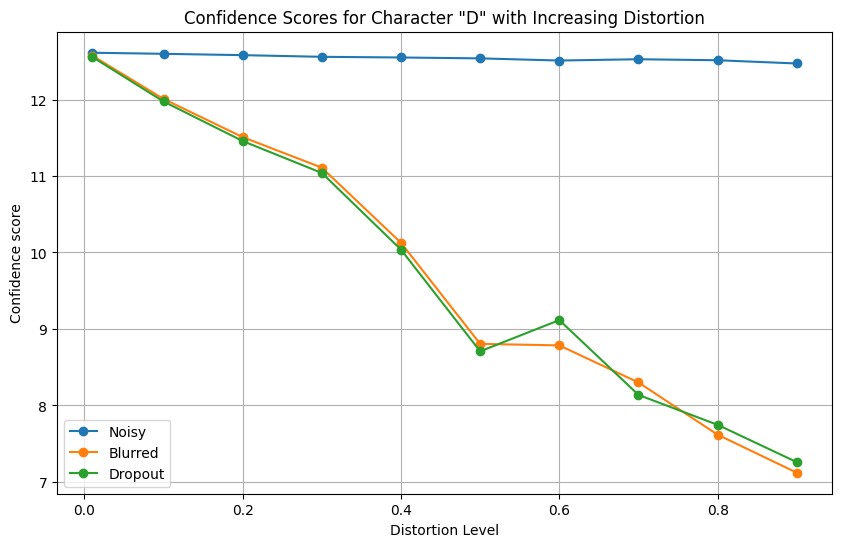

In [283]:
def make_test_cases(char_idx, perfect_vector):
    confidence_scores = pd.DataFrame(columns=['confidence_noisy', 'confidence_blurred', 'confidence_dropout', 'distortion_level'])
    for i in range(10):
        i = i / 10 if i != 0 else 0.01
        input_blurred = make_blurred(perfect_vector, blur_level=i)
        input_noisy = make_noisy(perfect_vector, noise_level=i)
        input_dropout = make_noisy(input_blurred, noise_level=i)
        
        confidence_scores.loc[len(confidence_scores)] = [
            NN1[char_idx] @ input_noisy,
            NN1[char_idx] @ input_blurred,
            NN1[char_idx] @ input_dropout,
            i
        ]
        
    return confidence_scores

def plot_test_cases(confidence_scores, char):
    plt.figure(figsize=(10, 6))
    plt.plot(confidence_scores['distortion_level'], confidence_scores['confidence_noisy'], label='Noisy', marker='o')
    plt.plot(confidence_scores['distortion_level'], confidence_scores['confidence_blurred'], label='Blurred', marker='o')
    plt.plot(confidence_scores['distortion_level'], confidence_scores['confidence_dropout'], label='Dropout', marker='o')
    plt.title(f'Confidence Scores for Character "{char.upper()}" with Increasing Distortion')
    plt.xlabel('Distortion Level')
    plt.ylabel('Confidence score')
    plt.legend()
    plt.grid(True)
    plt.show()
    

char = 'd'
char_idx = chars.index(char)

conf_scores = make_test_cases(char_idx, eval(f"{char}_perfect"))
plot_test_cases(conf_scores, char)

Can be seen that with rising distortion and blurryness, the confidence drops. Interestingly enough the noisy characters remain confidence, the matrix vector multiplication takes the very confident actual pieces over the noisy pieces.

## Test faultiness on combined distortions

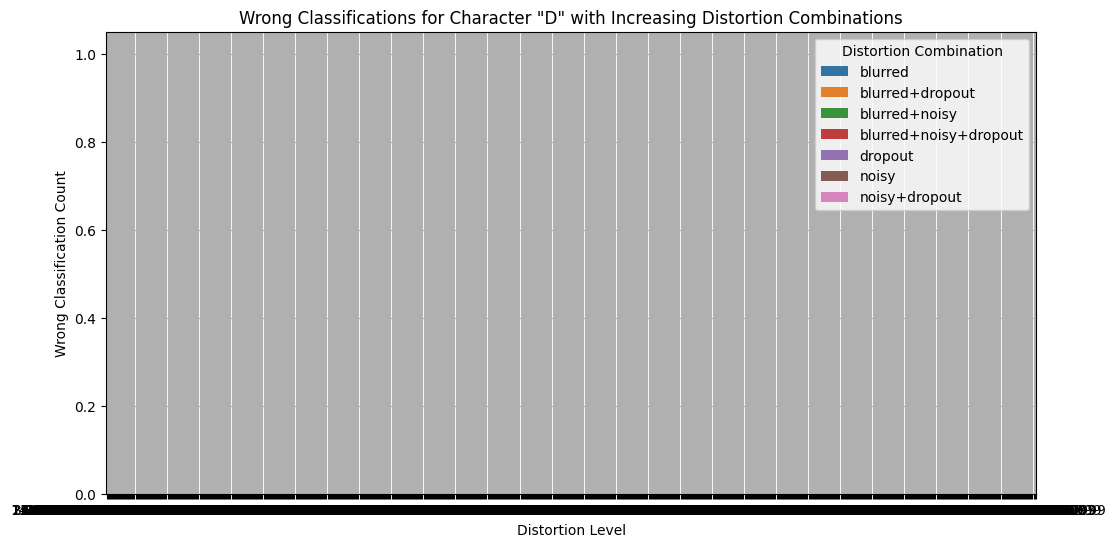

In [ ]:
def make_test_cases(char_idx, perfect_vector, iterations=10):
    distortion_combs = pd.DataFrame(columns=['distortion_level', 'type_combination', 'wrong_classification_count'])
    for i in range(10):
        for _ in range(iterations):
            i = i / 10 if i != 0 else 0.01
            input_blurred = make_blurred(perfect_vector, blur_level=i)
            input_noisy = make_noisy(perfect_vector, noise_level=i)
            input_dropout = make_dropout(input_blurred, drop_prob=i)
            
            combinations = {
                'noisy': input_noisy,
                'blurred': input_blurred,
                'dropout': input_dropout,
                'blurred+noisy': make_noisy(input_blurred, noise_level=i),
                'blurred+dropout': make_dropout(input_blurred, drop_prob=i),
                'noisy+dropout': make_dropout(input_noisy, drop_prob=i),
                'blurred+noisy+dropout': make_dropout(make_noisy(input_blurred, noise_level=i), drop_prob=i)
            }
            
            for combo_name, combo_vector in combinations.items():
                result = NN1 @ combo_vector
                predicted_char_idx = np.argmax(result)
                wrong_classification = 1 if predicted_char_idx != char_idx else 0
                
                distortion_combs.loc[len(distortion_combs)] = [
                    i,
                    combo_name,
                    wrong_classification
                ]
    
    return distortion_combs


def plot_test_cases(distortion_combs, char):
    # Group by distortion level and type combination, summing wrong classifications
    distortion_combs = distortion_combs.groupby(['distortion_level', 'type_combination']).sum().reset_index()
    
    # bar plot
    plt.figure(figsize=(12, 6))
    sns.barplot(data=distortion_combs, x='distortion_level', y='wrong_classification_count', hue='type_combination')
    plt.title(f'Wrong Classifications for Character "{char.upper()}" with Increasing Distortion Combinations')
    plt.xlabel('Distortion Level')
    plt.ylabel('Wrong Classification Count')
    plt.legend(title='Distortion Combination')
    plt.grid(True)
    plt.show()
   
char = 'd'
char_idx = chars.index(char)
    
distortion_combs = make_test_cases(char_idx, eval(f"{char}_perfect"))
plot_test_cases(distortion_combs, char)